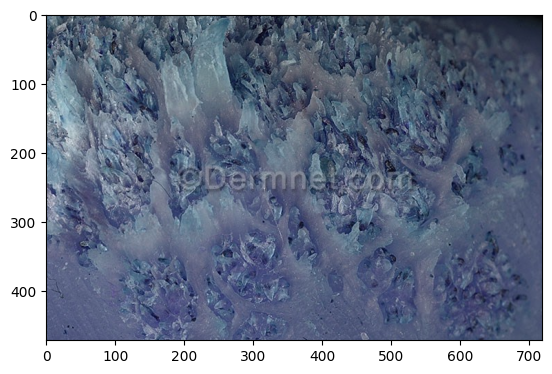

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = r"C:\Users\acer\Downloads\w1867202\SDGP\Dataset"
CATEGORIES = ['Chickenpox','Mild','Monkeypox','Normal','Severe']

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
#         plt.show()
#         break
#     break
                

In [2]:
 print(img_array)

[[[ 94 119 135]
  [102 127 143]
  [102 127 147]
  ...
  [ 10   7   9]
  [ 10   7   9]
  [ 11   8  10]]

 [[101 126 142]
  [106 131 147]
  [105 130 150]
  ...
  [ 10   7   9]
  [  9   6   8]
  [  9   6   8]]

 [[ 89 114 130]
  [ 98 123 139]
  [101 126 146]
  ...
  [  7   6   8]
  [  9   6   8]
  [  8   5   7]]

 ...

 [[ 75  84 118]
  [ 81  90 124]
  [ 90  98 135]
  ...
  [ 79  90 118]
  [ 78  89 117]
  [ 76  87 115]]

 [[ 76  85 119]
  [ 77  86 120]
  [ 85  93 130]
  ...
  [ 78  89 117]
  [ 78  89 117]
  [ 77  88 116]]

 [[ 80  89 123]
  [ 75  84 118]
  [ 82  90 127]
  ...
  [ 77  88 116]
  [ 78  89 117]
  [ 78  89 117]]]


In [3]:
print(img_array.shape)

(472, 720, 3)


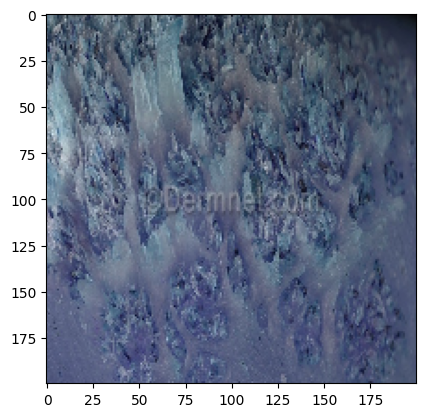

In [4]:
IMG_SIZE=200

new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [18]:
training_data = []

def create_training_data():
    
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)): # allows for the generation of progress bars
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
        
create_training_data()
      

100%|██████████| 319/319 [00:04<00:00, 68.83it/s]


In [10]:
print(len(training_data))

1328


In [22]:
# shuffle training data
import random

random.shuffle(training_data)
# print(training_data)

In [23]:
#check shuffle
for x in training_data[:10]:
    print(x[1])


1
1
3
1
0
4
1
1
4
4
